In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import time
from dateutil.relativedelta import *
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_rows', 100)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
import os, sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')

### allows to direct changes in the packages to be immidiately visibe in the notebook 
%load_ext autoreload
%autoreload 2


In [3]:
file = '../data/index_price.csv'
df_quotes = pd.read_csv(file, sep = ';')
df_quotes.index = pd.to_datetime(df_quotes.Datetime)

ticker = '^GSPC'
df_data = df_quotes[df_quotes['Symbol']==ticker]

In [4]:
df_data.head()

,Datetime,Open,High,Low,Close,Volume,Symbol,Adj_Close
Datetime,,,,,,,,
2010-01-04 15:30:00,2010-01-04 15:30:00,1116.560059,1133.869995,1116.560059,1132.989990,3.991400e+09,^GSPC,1132.989990
2010-01-05 15:30:00,2010-01-05 15:30:00,1132.660034,1136.630005,1129.660034,1136.520020,2.491020e+09,^GSPC,1136.520020
2010-01-06 15:30:00,2010-01-06 15:30:00,1135.709961,1139.189941,1133.949951,1137.140015,4.972660e+09,^GSPC,1137.140015
2010-01-07 15:30:00,2010-01-07 15:30:00,1136.270020,1142.459961,1131.319946,1141.689941,5.270680e+09,^GSPC,1141.689941
2010-01-08 15:30:00,2010-01-08 15:30:00,1140.520020,1145.390015,1136.219971,1144.979980,4.389590e+09,^GSPC,1144.979980


In [5]:
df_price = pd.DataFrame()
df_price['ds'] = pd.to_datetime(df_data.Datetime)
df_price['y'] = df_data['Close']
df_price = df_price.reset_index(drop=True)
df_price

,ds,y
0,2010-01-04 15:30:00,1132.989990
1,2010-01-05 15:30:00,1136.520020
2,2010-01-06 15:30:00,1137.140015
3,2010-01-07 15:30:00,1141.689941
4,2010-01-08 15:30:00,1144.979980
...,...,...
2668,2020-08-10 15:30:00,3360.469971
2669,2020-08-11 15:30:00,3333.689941
2670,2020-08-12 15:30:00,3380.350098
2671,2020-08-13 15:30:00,3373.429932


In [6]:
test_window = 7 ### days
max_rows = df_price.shape[0]

df_train = df_price[0:max_rows-test_window]
df_test = df_price[max_rows-test_window:max_rows]
df_train.shape, df_test.shape

((2666, 2), (7, 2))

In [7]:
df_train.tail(test_window)

,ds,y
2659,2020-07-28 15:30:00,3218.439941
2660,2020-07-29 15:30:00,3258.439941
2661,2020-07-30 15:30:00,3246.219971
2662,2020-07-31 15:30:00,3271.120117
2663,2020-08-03 15:30:00,3294.610107
2664,2020-08-04 15:30:00,3306.510010
2665,2020-08-05 15:30:00,3327.770020


In [8]:
df_test.tail(test_window)

,ds,y
2666,2020-08-06 15:30:00,3349.159912
2667,2020-08-07 15:30:00,3351.280029
2668,2020-08-10 15:30:00,3360.469971
2669,2020-08-11 15:30:00,3333.689941
2670,2020-08-12 15:30:00,3380.350098
2671,2020-08-13 15:30:00,3373.429932
2672,2020-08-14 15:30:00,3372.850098


In [10]:
ml_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
ml_prophet.fit(df_train)

In [11]:
fcast_time=test_window
df_forecast = ml_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)

In [12]:
# Forecasting - call the method predict
df_forecast = ml_prophet.predict(df_forecast)

In [13]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04 15:30:00,1128.733330,1022.160441,1244.312529
1,2010-01-05 15:30:00,1132.685715,1030.294347,1238.238948
2,2010-01-06 15:30:00,1132.784571,1025.409836,1237.426337
3,2010-01-07 15:30:00,1133.889024,1025.191926,1243.371078
4,2010-01-08 15:30:00,1135.309682,1029.385776,1250.774915
...,...,...,...,...
2668,2020-08-08 15:30:00,3083.843054,2975.369253,3192.401069
2669,2020-08-09 15:30:00,2961.984743,2857.401947,3068.942089
2670,2020-08-10 15:30:00,3107.279860,2993.024210,3212.906584
2671,2020-08-11 15:30:00,3107.535446,2994.371907,3213.015667


### Cross Validation

#### This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon. Checkout the source https://facebook.github.io/prophet/docs/diagnostics.html

![title](../data/diagnostics_3_0.png)

In [13]:
cutoffs = pd.to_datetime(['2020-07-23', '2020-08-01', '2018-08-15'])

In [14]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')

INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-02-25 15:30:00 and 2020-07-22 15:30:00


In [17]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
376,2020-07-30 15:30:00,3114.707554,3010.465909,3222.002343,3246.219971,2020-07-22 15:30:00
377,2020-07-31 15:30:00,3112.901688,3004.031733,3219.895283,3271.120117,2020-07-22 15:30:00
378,2020-08-03 15:30:00,3105.692670,3001.133212,3213.548760,3294.610107,2020-07-22 15:30:00
379,2020-08-04 15:30:00,3106.124081,2995.353238,3216.300242,3306.510010,2020-07-22 15:30:00
380,2020-08-05 15:30:00,3102.633426,2996.846280,3211.951709,3327.770020,2020-07-22 15:30:00


In [18]:
df_p = performance_metrics(df_cv)

In [19]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days 00:00:00,5680.853666,75.371438,46.773511,0.020461,0.015112,0.681174
1,2 days 23:00:00,5663.192682,75.254187,47.126214,0.020517,0.016454,0.686235
2,3 days 00:00:00,6640.232355,81.487621,50.124588,0.022620,0.013984,0.562753
3,3 days 23:00:00,6378.344252,79.864537,49.632274,0.022236,0.013984,0.582996
4,4 days 00:00:00,6412.384835,80.077368,48.592231,0.022318,0.013896,0.610526
5,4 days 23:00:00,5952.360137,77.151540,46.874789,0.021384,0.012218,0.648421
6,5 days 00:00:00,5817.899556,76.275157,48.314396,0.022566,0.014168,0.562753
7,5 days 23:00:00,5503.303078,74.184251,46.915276,0.021850,0.013518,0.582996
8,6 days 00:00:00,7473.123254,86.447228,58.610073,0.028067,0.017757,0.480549
9,6 days 23:00:00,7189.510699,84.790982,57.010876,0.027235,0.017757,0.508009


### Ploting

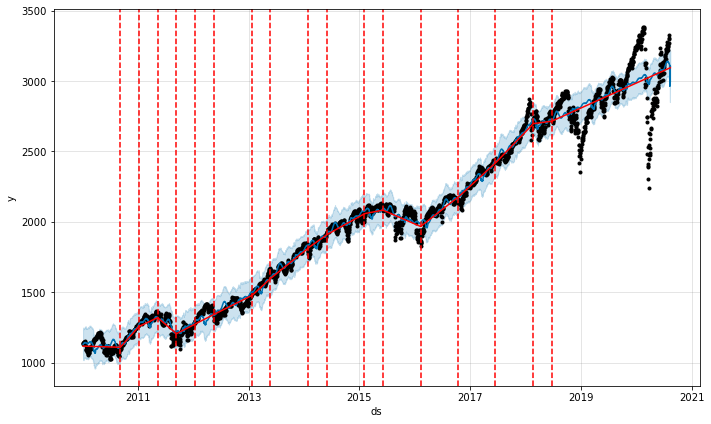

In [20]:
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)

### Adding seasonality, and by increasing changepoint_prior_scale, we got more flexible fit 

In [49]:
df_prophet = Prophet(changepoint_prior_scale=0.5, holidays=None, daily_seasonality=True,
                     weekly_seasonality=True, yearly_seasonality=True)

In [50]:
#### another method to add seasonality effect is via the fourior basis functions, change in the value of period will result in different seasonality effect
#df_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#df_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

In [51]:
df_prophet.fit(df_train)

In [52]:
fcast_time=test_window
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)

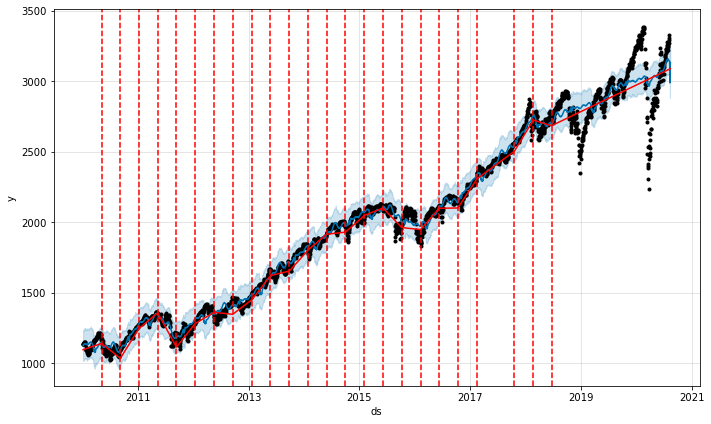

In [53]:
df_forecast = df_prophet.predict(df_forecast)
#df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)


#### Again test the results using CV

In [ ]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')
df_p = performance_metrics(df_cv)

# Hyper-parameter tuning

In [54]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range': [0.85, 0.90, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [55]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_price)  # Fit model with given params
    df_cv = cross_validation(m,  initial='2600', period='100 days', horizon = '7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


In [56]:
#df_p
#min(rmses)
#len(rmses)
#rmses

In [58]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
#print(tuning_results)

#### Do argmax

In [59]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


In [60]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.95}

In [14]:
#mdl_prophet = Prophet(**best_params)
mdl_prophet = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, seasonality_mode= 'multiplicative', changepoint_range=0.95)

In [15]:
mdl_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
fcast_time=9
df_forecast = mdl_prophet.make_future_dataframe(periods=fcast_time, freq='D', include_history=True)
df_forecast = mdl_prophet.predict(df_forecast)

In [19]:
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-04 15:30:00,515.587275,1066.820834,1257.344137,515.587275,515.587275,1.267311,1.267311,1.267311,1.300878,1.300878,1.300878,-0.033566,-0.033566,-0.033566,0.0,0.0,0.0,1168.996860
1,2010-01-05 15:30:00,515.407327,1072.241021,1261.757963,515.407327,515.407327,1.261009,1.261009,1.261009,1.294308,1.294308,1.294308,-0.033299,-0.033299,-0.033299,0.0,0.0,0.0,1165.340393
2,2010-01-06 15:30:00,515.227378,1080.434995,1255.728905,515.227378,515.227378,1.263200,1.263200,1.263200,1.296143,1.296143,1.296143,-0.032943,-0.032943,-0.032943,0.0,0.0,0.0,1166.062407
3,2010-01-07 15:30:00,515.047429,1069.276066,1261.241264,515.047429,515.047429,1.262879,1.262879,1.262879,1.295412,1.295412,1.295412,-0.032533,-0.032533,-0.032533,0.0,0.0,0.0,1165.489947
4,2010-01-08 15:30:00,514.867481,1070.348945,1253.935097,514.867481,514.867481,1.256977,1.256977,1.256977,1.289080,1.289080,1.289080,-0.032102,-0.032102,-0.032102,0.0,0.0,0.0,1162.044233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,2020-08-10 15:30:00,1291.940945,3000.785136,3183.819224,1291.940945,1291.940945,1.391473,1.391473,1.391473,1.300878,1.300878,1.300878,0.090596,0.090596,0.090596,0.0,0.0,0.0,3089.642287
2671,2020-08-11 15:30:00,1291.414787,2993.487285,3169.597143,1291.414787,1291.414787,1.382737,1.382737,1.382737,1.294308,1.294308,1.294308,0.088429,0.088429,0.088429,0.0,0.0,0.0,3077.101705
2672,2020-08-12 15:30:00,1290.888629,2979.971732,3165.811860,1290.888629,1290.888629,1.382574,1.382574,1.382574,1.296143,1.296143,1.296143,0.086431,0.086431,0.086431,0.0,0.0,0.0,3075.637587
2673,2020-08-13 15:30:00,1290.362471,2980.798500,3169.249296,1290.362471,1290.362471,1.380039,1.380039,1.380039,1.295412,1.295412,1.295412,0.084627,0.084627,0.084627,0.0,0.0,0.0,3071.113165


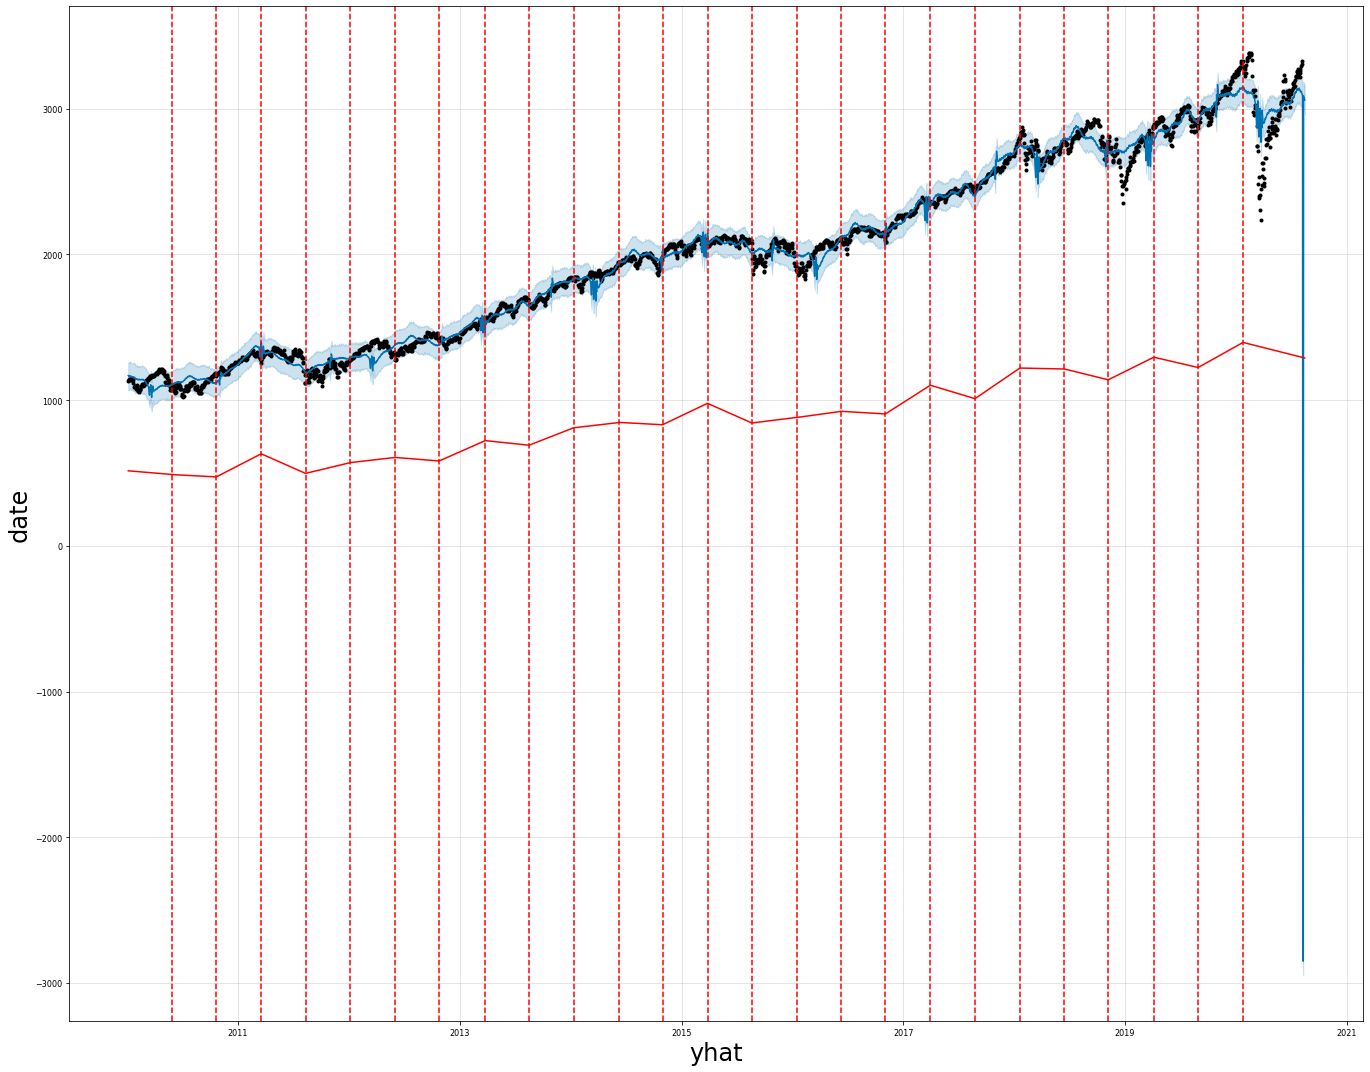

In [26]:
from matplotlib import pyplot as plt 
fig = df_prophet.plot(df_forecast)
fig.set_size_inches(20, 16)
plt.xlabel('yhat', fontsize=24)
plt.ylabel('date', fontsize=24)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
a = add_changepoints_to_plot(fig.gca(), mdl_prophet, df_forecast)

## Lets measure cross-validation error

In [23]:
df_cv = cross_validation(mdl_prophet, initial='2600', period='500 days', horizon = '7 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2010-12-29 15:30:00 and 2020-07-29 15:30:00


In [24]:
df_p = performance_metrics(df_cv)

In [25]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 00:00:00,8294.036292,91.071600,57.684902,0.021005,0.012188,0.7500
1,1 days 23:00:00,9389.459338,96.899223,71.410311,0.025691,0.026066,0.5625
2,2 days 00:00:00,9636.983510,98.168139,53.985044,0.019109,0.010031,0.8000
3,2 days 23:00:00,10467.808415,102.312308,68.949593,0.024409,0.027307,0.6000
4,3 days 00:00:00,182.519869,13.509991,11.039655,0.006168,0.004910,1.0000
5,3 days 23:00:00,6499.849071,80.621641,48.163821,0.018596,0.007786,0.7500
6,4 days 00:00:00,1891.461117,43.490931,30.425425,0.015016,0.009857,0.5000
7,4 days 23:00:00,2173.390310,46.619634,36.555830,0.016167,0.009857,0.3750
8,5 days 00:00:00,11899.342577,109.084108,59.661991,0.021215,0.014538,0.6000
9,6 days 00:00:00,12501.559675,111.810374,62.280387,0.023649,0.017449,0.5000
